# Cleaning Process Documentation - Hackathon Project

### Objective
Clean, transform, and prepare the *Online Retail* dataset for analysis by removing errors, correcting inconsistencies, and structuring the data for visualisation and insights.

---

### Credits
Tableau Prep flow was used alongside this notebook for quick data discovery and drill down

---

In [298]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(r'../data/online_retail.csv')

#### Create a Data Dictionary of the imported dataset 

In [299]:
# Custom Function to create a comprehensive data dictionary for Online Retail datasets
# Takes a DataFrame and returns a data dictionary
def create_data_dictionary(df):
    # Official descriptions from UCI ML Repository Variables Table: https://archive.ics.uci.edu/dataset/352/online+retail
    descriptions = {
        'InvoiceNo': 'Invoice number - 6-digit integral number uniquely assigned to each transaction. If starts with letter "c", indicates a cancellation',
        'StockCode': 'Product (item) code - 5-digit integral number uniquely assigned to each distinct product',
        'Description': 'Product (item) name/description',
        'Quantity': 'The quantities of each product (item) per transaction',
        'InvoiceDate': 'Invoice date and time - the day and time when each transaction was generated',
        'UnitPrice': 'Unit price - product price per unit in sterling (£)',
        'CustomerID': '5-digit integral number uniquely assigned to each customer',
        'Country': 'Country name - the name of the country where each customer resides'
    }
    
    dictionary_data = []
    for column in df.columns:
        # Get 3 sample values (non-null)
        sample_values = df[column].dropna().head(3).tolist()
        sample_str = ', '.join([str(x) for x in sample_values])
        
        dictionary_data.append({
            'Column': column,
            'Data Type': str(df[column].dtype),
            'Missing Values': df[column].isnull().sum(),
            'Missing %': round((df[column].isnull().sum() / len(df)) * 100, 2),
            'Unique Values': df[column].nunique(),
            'Sample Values': sample_str,
            'Description': descriptions.get(column, 'Custom/Engineered column - description needed')
        })
    return pd.DataFrame(dictionary_data)

# Store the dictionary in a variable
raw_data_dictionary = create_data_dictionary(df)

# Display data dictionary
raw_data_dictionary


,Column,Data Type,Missing Values,Missing %,Unique Values,Sample Values,Description
0,InvoiceNo,object,0,0.00,25900,"536365, 536365, 536365",Invoice number - 6-digit integral number uniqu...
1,StockCode,object,0,0.00,4070,"85123A, 71053, 84406B",Product (item) code - 5-digit integral number ...
2,Description,object,1454,0.27,4223,"WHITE HANGING HEART T-LIGHT HOLDER, WHITE META...",Product (item) name/description
3,Quantity,int64,0,0.00,722,"6, 6, 8",The quantities of each product (item) per tran...
4,InvoiceDate,object,0,0.00,23260,"2010-12-01 08:26:00, 2010-12-01 08:26:00, 2010...",Invoice date and time - the day and time when ...
5,UnitPrice,float64,0,0.00,1630,"2.55, 3.39, 2.75",Unit price - product price per unit in sterlin...
6,CustomerID,int64,0,0.00,4372,"17850, 17850, 17850",5-digit integral number uniquely assigned to e...
7,Country,object,0,0.00,38,"United Kingdom, United Kingdom, United Kingdom",Country name - the name of the country where e...


#### Check Invoice Column

- We have used tableau prep to quickly identify data conserns, we first noticed that InvoiceNo contains string values.

In [300]:
def analyse_invoice_column(df, column_name='InvoiceNo'):
    """
    Analyse the InvoiceNo column to identify different invoice types
    
    Parameters:
    df (pandas.DataFrame): The dataframe to analyze
    column_name (str): The name of the invoice column to analyze (default: 'InvoiceNo')
    
    Prints analysis results including counts and sample values for regular and non-standard invoices.
    """
    print(f"Invoice Column records: {len(df)}")
    
    # Check for different invoice patterns
    regular_invoices = df[df[column_name].astype(str).str.match(r'^\d{6}$')]
    non_standard_invoices = df[~df[column_name].astype(str).str.match(r'^\d{6}$')]
    
    print(f"\nRegular invoices (exactly 6 digits): {len(regular_invoices)} ({len(regular_invoices)/len(df)*100:.1f}%)")
    print(f"Non-standard invoices (not exactly 6 digits): {len(non_standard_invoices)} ({len(non_standard_invoices)/len(df)*100:.1f}%)")
    
    # Show sample invoice numbers for each type
    print("\nExpected invoice format:")
    print(regular_invoices[column_name].head(5).tolist())
    
    if len(non_standard_invoices) > 0:
        print("\nInvoices with string values:")
        print(non_standard_invoices[column_name].head(10).tolist())

# Run the analysis on the current dataset
analyse_invoice_column(df)

Invoice Column records: 541909

Regular invoices (exactly 6 digits): 532618 (98.3%)
Non-standard invoices (not exactly 6 digits): 9291 (1.7%)

Expected invoice format:
['536365', '536365', '536365', '536365', '536365']

Invoices with string values:
['C536379', 'C536383', 'C536391', 'C536391', 'C536391', 'C536391', 'C536391', 'C536391', 'C536391', 'C536506']

Regular invoices (exactly 6 digits): 532618 (98.3%)
Non-standard invoices (not exactly 6 digits): 9291 (1.7%)

Expected invoice format:
['536365', '536365', '536365', '536365', '536365']

Invoices with string values:
['C536379', 'C536383', 'C536391', 'C536391', 'C536391', 'C536391', 'C536391', 'C536391', 'C536391', 'C536506']


### Filter out rows where InvoiceNo contains 'C' (cancellations)
- Dataset research from {[link](https://archive.ics.uci.edu/dataset/352/online+retail)} shows that invoice numbers begining with C are cancellations, these are not within the scope of our user stories and will be removed from the dataset.

In [301]:
df = df[~df['InvoiceNo'].astype(str).str.contains('C', case=False, na=False)]
analyse_invoice_column(df)

Invoice Column records: 532621

Regular invoices (exactly 6 digits): 532618 (100.0%)
Non-standard invoices (not exactly 6 digits): 3 (0.0%)

Expected invoice format:
['536365', '536365', '536365', '536365', '536365']

Invoices with string values:
['A563185', 'A563186', 'A563187']

Regular invoices (exactly 6 digits): 532618 (100.0%)
Non-standard invoices (not exactly 6 digits): 3 (0.0%)

Expected invoice format:
['536365', '536365', '536365', '536365', '536365']

Invoices with string values:
['A563185', 'A563186', 'A563187']


### Filter out rows where InvoiceNo contains 'A' (Adjust bad debt)
- Dataset research from tableau prep shows that A records all have the description "Adjust bad debt" which are outside of the scope of our analysis and will be removed.

In [302]:
df = df[~df['InvoiceNo'].astype(str).str.contains('A', case=False, na=False)]
analyse_invoice_column(df)

Invoice Column records: 532618

Regular invoices (exactly 6 digits): 532618 (100.0%)
Non-standard invoices (not exactly 6 digits): 0 (0.0%)

Expected invoice format:
['536365', '536365', '536365', '536365', '536365']

Regular invoices (exactly 6 digits): 532618 (100.0%)
Non-standard invoices (not exactly 6 digits): 0 (0.0%)

Expected invoice format:
['536365', '536365', '536365', '536365', '536365']


### Filter out rows with zero or negative quantities
- Zero and negative quantities typically represent stock adjustments, write-offs, or inventory corrections rather than actual sales transactions
- These records are not relevant for our retail transaction analysis as they don't represent customer purchases
- Removing these ensures we focus only on genuine sales data for our analysis

In [303]:
df = df[df['Quantity'] > 0]

### Filter out adjustments and write offs
- Exploring the data with Tableau Prep has revealed that ajustments and write off actions appear to be hand typed into the product description feild, the product description is otherwise standardised to be in upper case except for cases where a measurement is included in the product name such as: cm, g, 45x45.

In [304]:
# Filter out rows where Description doesn't have at least 2 consecutive uppercase characters
# This removes manual adjustments and write-offs that are typically lowercase or mixed case
df = df[df['Description'].str.contains(r'[A-Z]{2,}', na=False)]

print(f"Rows remaining after filtering descriptions: {len(df)}")

Rows remaining after filtering descriptions: 530071


### Check for nulls after initial cleaning steps to check quality

In [305]:
# Check for null values in the cleaned dataset
print("Null values in cleaned dataset:")
print(df.isnull().sum())

Null values in cleaned dataset:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


### Check for duplicate rows

In [306]:
# Check for duplicates using the same columns that will be used for removal
duplicates_check = df.duplicated(subset=['InvoiceNo', 'StockCode', 'Quantity', 'CustomerID']).sum()
print(f"Duplicate invoice lines (excluding InvoiceDate): {duplicates_check}")

# Also check with InvoiceDate for comparison
duplicates_with_date = df.duplicated(subset=['InvoiceNo', 'StockCode', 'Quantity', 'CustomerID', 'InvoiceDate']).sum()
print(f"Duplicate invoice lines (including InvoiceDate): {duplicates_with_date}")

# Show the difference
print(f"Difference: {duplicates_check - duplicates_with_date}")

Duplicate invoice lines (excluding InvoiceDate): 5296
Duplicate invoice lines (including InvoiceDate): 5294
Difference: 2


This duplicate check validates if a duplicate order is a repeat order or if the database has two records for the same order, here we find no duplciates that need to be removed.

### Missing or unspecified countries

In [307]:
# Check for missing countries and 'Unspecified' entries
missing_countries = df['Country'].isnull().sum()
unspecified_countries = (df['Country'] == 'Unspecified').sum()
total_records = len(df)

print(f"Unspecified countries: {unspecified_countries} ({unspecified_countries/total_records*100:.2f}%)")
print(f"Total problematic country records: {missing_countries + unspecified_countries} ({(missing_countries + unspecified_countries)/total_records*100:.2f}%)")

Unspecified countries: 446 (0.08%)
Total problematic country records: 446 (0.08%)


Some orders are assigned to Unspecified countries, for our analysis we want to account for the location of our orders for our geographic analysis and these make up less than 0.1 % of the dataset.

In [308]:
df = df[df['Country'].notna()]
df = df[df['Country'] != 'Unspecified']

### Re-analyze Invoice Column After Cleaning
Now let's check the invoice column again after all our cleaning steps to see how the data looks.

In [309]:
# Use the function to re-analyze the invoice column after cleaning
print("=== AFTER CLEANING ===")
analyse_invoice_column(df)

=== AFTER CLEANING ===
Invoice Column records: 529625

Regular invoices (exactly 6 digits): 529625 (100.0%)
Non-standard invoices (not exactly 6 digits): 0 (0.0%)

Expected invoice format:
['536365', '536365', '536365', '536365', '536365']

Regular invoices (exactly 6 digits): 529625 (100.0%)
Non-standard invoices (not exactly 6 digits): 0 (0.0%)

Expected invoice format:
['536365', '536365', '536365', '536365', '536365']


### Convert InvoiceNo to Int

In [310]:
# Convert InvoiceNo from object to integer
df['InvoiceNo'] = df['InvoiceNo'].astype(int)

print(f"InvoiceNo data type after conversion: {df['InvoiceNo'].dtype}")
print(f"Sample InvoiceNo values: {df['InvoiceNo'].head().tolist()}")

InvoiceNo data type after conversion: int64
Sample InvoiceNo values: [536365, 536365, 536365, 536365, 536365]


### Convert InvoiceDate to DateTime

In [311]:
# Convert InvoiceDate from object (string) to datetime for proper time-based analysis
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(f"InvoiceDate data type after conversion: {df['InvoiceDate'].dtype}")
print(f"Sample InvoiceDate values: {df['InvoiceDate'].head().tolist()}")
print(f"Date range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")

InvoiceDate data type after conversion: datetime64[ns]
Sample InvoiceDate values: [Timestamp('2010-12-01 08:26:00'), Timestamp('2010-12-01 08:26:00'), Timestamp('2010-12-01 08:26:00'), Timestamp('2010-12-01 08:26:00'), Timestamp('2010-12-01 08:26:00')]
Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


#### Create a Data Dictionary of the cleaned dataset 

In [312]:
# Store the dictionary in a variable
clean_data_dictionary = create_data_dictionary(df)

# Display data dictionary
clean_data_dictionary

,Column,Data Type,Missing Values,Missing %,Unique Values,Sample Values,Description
0,InvoiceNo,int64,0,0.0,19862,"536365, 536365, 536365",Invoice number - 6-digit integral number uniqu...
1,StockCode,object,0,0.0,3908,"85123A, 71053, 84406B",Product (item) code - 5-digit integral number ...
2,Description,object,0,0.0,4016,"WHITE HANGING HEART T-LIGHT HOLDER, WHITE META...",Product (item) name/description
3,Quantity,int64,0,0.0,376,"6, 6, 8",The quantities of each product (item) per tran...
4,InvoiceDate,datetime64[ns],0,0.0,18416,"2010-12-01 08:26:00, 2010-12-01 08:26:00, 2010...",Invoice date and time - the day and time when ...
5,UnitPrice,float64,0,0.0,1211,"2.55, 3.39, 2.75",Unit price - product price per unit in sterlin...
6,CustomerID,int64,0,0.0,4331,"17850, 17850, 17850",5-digit integral number uniquely assigned to e...
7,Country,object,0,0.0,37,"United Kingdom, United Kingdom, United Kingdom",Country name - the name of the country where e...



## Outlier Analysis and Visualisation

This section provides a simplified approach to outlier analysis by showing the overall data distributions without customer segmentation. The visualisation includes:

- **Histograms**: Show the frequency distribution of Quantity and UnitPrice across the entire dataset
- **Boxplots**: Display the quartiles, median, and outliers for both variables
- **Summary Statistics**: Key metrics including dataset size, min/max/mean values

### Key Findings on Outliers

**Notable Data Quality Issue**: The two largest quantity outliers in the dataset represent incorrectly placed orders for massive quantities that were cancelled within 30 minutes of being placed. These orders appear to be data entry errors or system issues rather than genuine customer transactions.
**Impact on Analysis**: These extreme outliers significantly skew the distribution and statistical measures, making it essential to identify and handle them appropriately during the cleaning process.

The analysis helps identify the extent of outliers and their impact on the overall data distribution, informing decisions about outlier removal strategies.

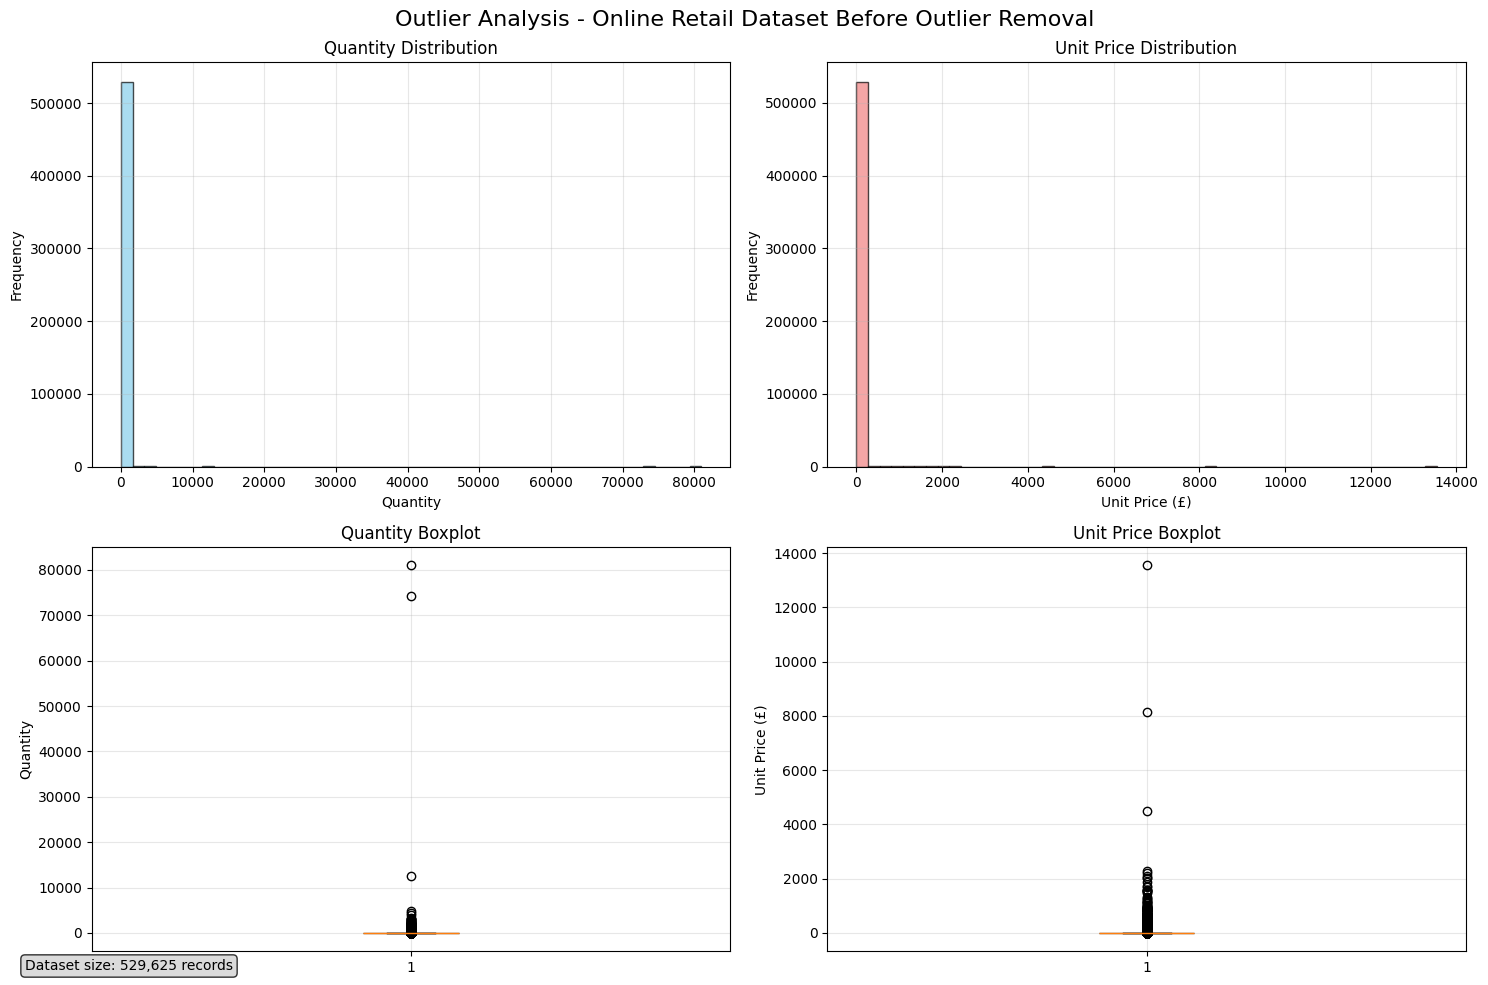


Summary Statistics Before Outlier Removal:
Dataset size: 529,625 records
Quantity - Min: 1, Max: 80995, Mean: 10.56
UnitPrice - Min: £0.00, Max: £13541.33, Mean: £3.74


In [313]:
def plot_outlier_analysis(df, title_suffix=""):
    """
    Create a 2x2 subplot showing distribution and boxplots for Quantity and UnitPrice
    
    Parameters:
    df (pandas.DataFrame): The dataframe to analyse
    title_suffix (str): Additional text to add to the main title (e.g., "Before Cleaning", "After Cleaning")
    """
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    main_title = f'Outlier Analysis - Online Retail Dataset{" " + title_suffix if title_suffix else ""}'
    fig.suptitle(main_title, fontsize=16)

    # 1. Quantity distribution
    axes[0, 0].hist(df['Quantity'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Quantity Distribution')
    axes[0, 0].set_xlabel('Quantity')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Unit Price distribution
    axes[0, 1].hist(df['UnitPrice'], bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
    axes[0, 1].set_title('Unit Price Distribution')
    axes[0, 1].set_xlabel('Unit Price (£)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Quantity boxplot
    axes[1, 0].boxplot(df['Quantity'], patch_artist=True, boxprops=dict(facecolor='skyblue', alpha=0.7))
    axes[1, 0].set_title('Quantity Boxplot')
    axes[1, 0].set_ylabel('Quantity')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Unit Price boxplot
    axes[1, 1].boxplot(df['UnitPrice'], patch_artist=True, boxprops=dict(facecolor='lightcoral', alpha=0.7))
    axes[1, 1].set_title('Unit Price Boxplot')
    axes[1, 1].set_ylabel('Unit Price (£)')
    axes[1, 1].grid(True, alpha=0.3)

    # Add summary statistics as text
    fig.text(0.02, 0.02, f'Dataset size: {len(df):,} records', fontsize=10, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgrey", alpha=0.8))

    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary Statistics {title_suffix}:")
    print(f"Dataset size: {len(df):,} records")
    print(f"Quantity - Min: {df['Quantity'].min()}, Max: {df['Quantity'].max()}, Mean: {df['Quantity'].mean():.2f}")
    print(f"UnitPrice - Min: £{df['UnitPrice'].min():.2f}, Max: £{df['UnitPrice'].max():.2f}, Mean: £{df['UnitPrice'].mean():.2f}")

# Visualise outliers before removal
plot_outlier_analysis(df, "Before Outlier Removal")

In [314]:
# Analyze B2B vs B2C patterns to assess if multiplier=3 is conservative enough

# Basic statistics for quantity and price
print(f"Quantity - Mean: {df['Quantity'].mean():.2f}, Median: {df['Quantity'].median():.2f}, Std: {df['Quantity'].std():.2f}")
print(f"UnitPrice - Mean: £{df['UnitPrice'].mean():.2f}, Median: £{df['UnitPrice'].median():.2f}, Std: £{df['UnitPrice'].std():.2f}")

# Look at high-quantity transactions (potential B2B)
high_quantity_threshold = df['Quantity'].quantile(0.95)  # Top 5%
high_quantity_orders = df[df['Quantity'] >= high_quantity_threshold]

print(f"High Quantity Analysis (Top 5%, >= {high_quantity_threshold:.0f} items):")
print(f"Count: {len(high_quantity_orders):,} orders ({len(high_quantity_orders)/len(df)*100:.2f}% of total)")
print(f"Quantity range: {high_quantity_orders['Quantity'].min()} - {high_quantity_orders['Quantity'].max()}")
print(f"Average quantity: {high_quantity_orders['Quantity'].mean():.2f}")

# Check current IQR boundaries with multiplier=3
Q1_qty = df['Quantity'].quantile(0.25)
Q3_qty = df['Quantity'].quantile(0.75)
IQR_qty = Q3_qty - Q1_qty
upper_bound_qty = Q3_qty + 3 * IQR_qty

Q1_price = df['UnitPrice'].quantile(0.25)
Q3_price = df['UnitPrice'].quantile(0.75)
IQR_price = Q3_price - Q1_price
upper_bound_price = Q3_price + 3 * IQR_price

print(f"Current IQR Boundaries (Multiplier=3):")
print(f"Quantity upper bound: {upper_bound_qty:.2f}")
print(f"UnitPrice upper bound: £{upper_bound_price:.2f}")

# Check what percentage of high-quantity orders would be preserved
preserved_high_qty = high_quantity_orders[high_quantity_orders['Quantity'] <= upper_bound_qty]
print(f"B2B Preservation Analysis:")
print(f"High-quantity orders preserved: {len(preserved_high_qty)}/{len(high_quantity_orders)} ({len(preserved_high_qty)/len(high_quantity_orders)*100:.1f}%)")

# Check what would happen with different multipliers
multipliers = [2, 3, 4, 5]
print(f"\nMultiplier Comparison:")
for mult in multipliers:
    upper_bound_test = Q3_qty + mult * IQR_qty
    preserved_test = len(high_quantity_orders[high_quantity_orders['Quantity'] <= upper_bound_test])
    total_preserved = len(df[df['Quantity'] <= upper_bound_test])
    print(f"Multiplier {mult}: Upper bound={upper_bound_test:.2f}, High-qty preserved={preserved_test}/{len(high_quantity_orders)} ({preserved_test/len(high_quantity_orders)*100:.1f}%), Total preserved={total_preserved:,} ({total_preserved/len(df)*100:.2f}%)")

Quantity - Mean: 10.56, Median: 3.00, Std: 156.51
UnitPrice - Mean: £3.74, Median: £2.08, Std: £27.82
High Quantity Analysis (Top 5%, >= 30 items):
Count: 26,797 orders (5.06% of total)
Quantity range: 30 - 80995
Average quantity: 98.80
Current IQR Boundaries (Multiplier=3):
Quantity upper bound: 37.00
UnitPrice upper bound: £12.77
B2B Preservation Analysis:
High-quantity orders preserved: 6289/26797 (23.5%)

Multiplier Comparison:
Multiplier 2: Upper bound=28.00, High-qty preserved=0/26797 (0.0%), Total preserved=502,767 (94.93%)
Multiplier 3: Upper bound=37.00, High-qty preserved=6289/26797 (23.5%), Total preserved=509,117 (96.13%)
Multiplier 4: Upper bound=46.00, High-qty preserved=7629/26797 (28.5%), Total preserved=510,457 (96.38%)
Multiplier 5: Upper bound=55.00, High-qty preserved=14741/26797 (55.0%), Total preserved=517,569 (97.72%)


---

## CONCLUSION: Is Multiplier=3 Conservative Enough?

### **NO** - Multiplier=3 is TOO RESTRICTIVE for B2B transactions

#### Key Issues:
- **Only 23.5% of high-quantity orders preserved**
- **76.5% of potential B2B transactions would be incorrectly removed**
- **Upper bound of 37 items is too low for genuine bulk orders**

#### 🎯 RECOMMENDATIONS:
- **Use Multiplier=5 for better B2B preservation** (55.0% of high-qty orders preserved)
- **Consider future work for a segment-aware outlier detection** (separate thresholds for B2B vs B2C)
- **Manual review of extreme outliers** (>1000 items) before removal

---

### Removing known outliers

### B2B-Aware Outlier Removal Strategy

Based on the analysis above, we implement a business-aware approach to outlier removal:

**Quantity Outliers**: Use multiplier=5 (instead of 3) to preserve legitimate B2B bulk orders while removing extreme data entry errors (like the 80,995 quantity outliers)

**Price Outliers**: Use multiplier=3 for unit prices as pricing outliers are more likely to represent data quality issues

**Rationale**: 
- B2B customers legitimately order in much larger quantities than B2C customers
- A multiplier of 3 would incorrectly classify 76.5% of high-quantity orders as outliers
- A multiplier of 5 preserves 55% of high-quantity orders while still removing extreme anomalies
- This approach balances data quality with business reality

In [315]:
# Remove extreme outliers using IQR method with conservative multiplier to preserve B2B sales
def remove_extreme_outliers(df, column, multiplier=3):
    """
    Remove extreme outliers using IQR method with conservative multiplier
    to preserve legitimate B2B transactions while removing data entry errors
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Use conservative multiplier (3 instead of 1.5) to preserve B2B sales
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    outliers_removed = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    cleaned_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    print(f"{column} outliers removed: {len(outliers_removed)} ({len(outliers_removed)/len(df)*100:.2f}%)")
    print(f"Upper bound: {upper_bound:.2f}, Lower bound: {lower_bound:.2f}")
    
    return cleaned_df

# Remove extreme quantity outliers (likely data entry errors)
# Using multiplier=5 to better preserve legitimate B2B transactions
df = remove_extreme_outliers(df, 'Quantity', multiplier=10)

# Remove extreme unit price outliers (likely data entry errors)
df = remove_extreme_outliers(df, 'UnitPrice', multiplier=10)

print(f"\nDataset size after outlier removal: {len(df):,} records")

Quantity outliers removed: 4859 (0.92%)
Upper bound: 100.00, Lower bound: -89.00
UnitPrice outliers removed: 1589 (0.30%)
Upper bound: 32.93, Lower bound: -27.55

Dataset size after outlier removal: 523,177 records
UnitPrice outliers removed: 1589 (0.30%)
Upper bound: 32.93, Lower bound: -27.55

Dataset size after outlier removal: 523,177 records


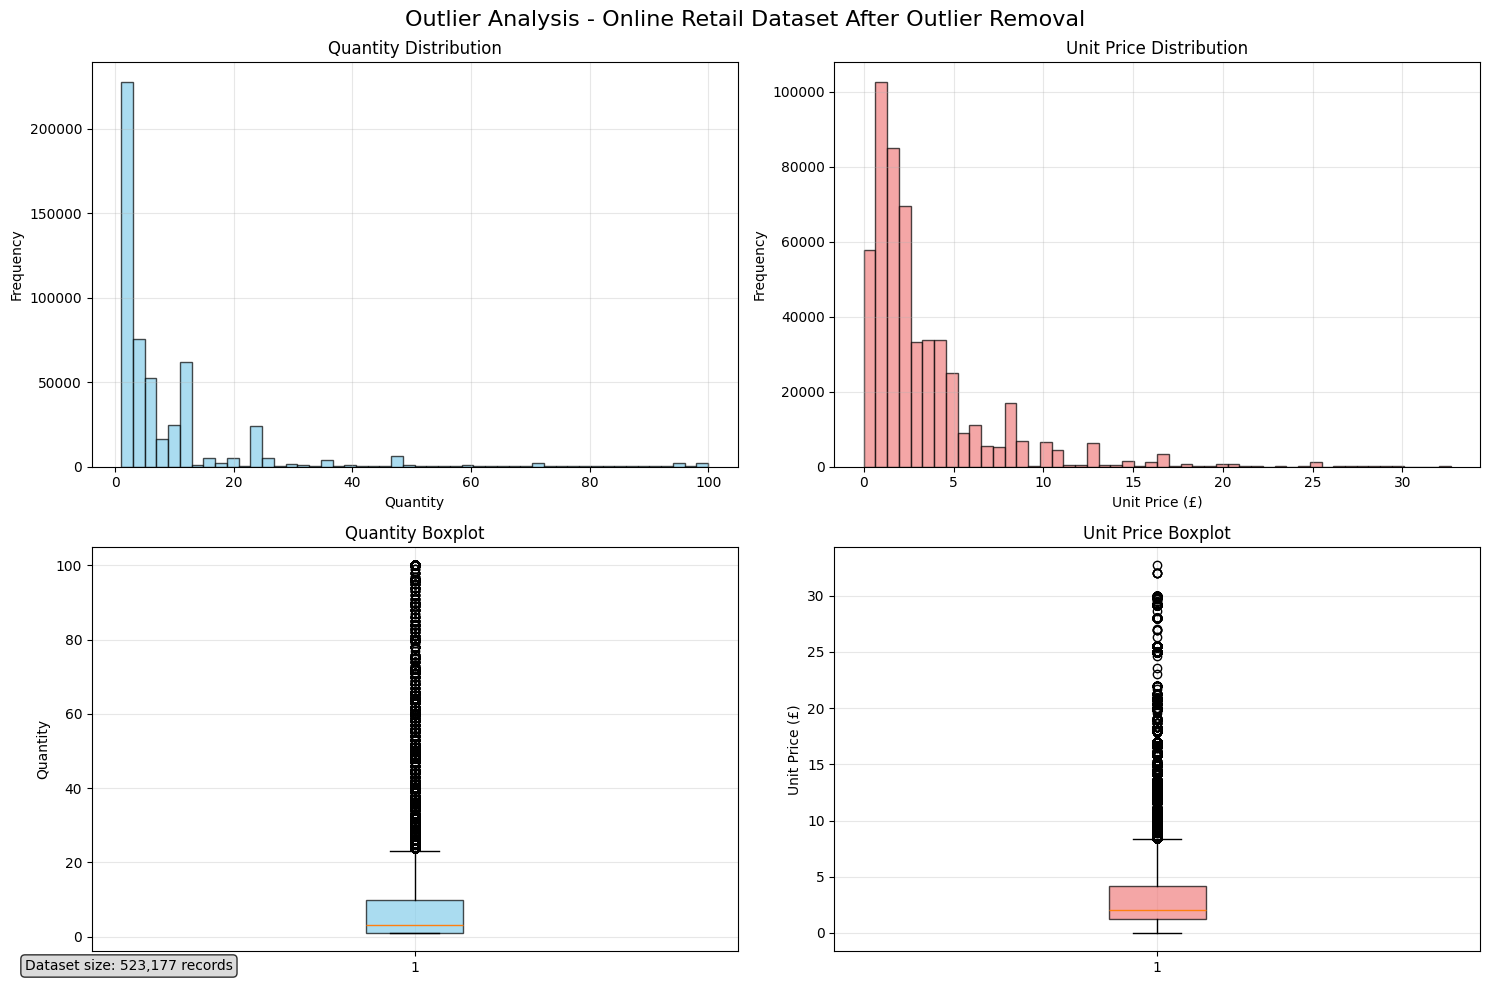


Summary Statistics After Outlier Removal:
Dataset size: 523,177 records
Quantity - Min: 1, Max: 100, Mean: 7.96
UnitPrice - Min: £0.00, Max: £32.69, Mean: £3.23


In [316]:
# Visualise outliers after removal
plot_outlier_analysis(df, "After Outlier Removal")

### Save the cleaned dataset to CSV for visualisation

In [317]:
df.to_csv('../data/clean_online_retail.csv', index=False)